In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

tf.enable_eager_execution()

def gray(images):
  return np.dot(images[..., :3], [0.299, 0.587, 0.114])

#(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = gray(x_train)

def create_shadow_model_64(input_dim=200, output_dim=1024):
  shadow_inputs = keras.Input(shape=(input_dim,), name='shadow_input')
  x = layers.Dense(128, activation='relu', name='dense_11')(shadow_inputs)
  x = layers.Dense(256, activation='relu', name='dense_12')(x)
  x = layers.Dense(64, activation='relu', name='dense_13')(x)
  shadow_outputs = layers.Dense(output_dim, activation='relu', name='predict')(x)
  return keras.Model(inputs=shadow_inputs, outputs=shadow_outputs)

def create_shadow_model_128(input_dim=200, output_dim=1024):
  shadow_inputs = keras.Input(shape=(input_dim,), name='shadow_input')
  x = layers.Dense(128, activation='relu', name='dense_11')(shadow_inputs)
  x = layers.Dense(256, activation='relu', name='dense_12')(x)
  x = layers.Dense(128, activation='relu', name='dense_13')(x)
  shadow_outputs = layers.Dense(output_dim, activation='relu', name='predict')(x)
  return keras.Model(inputs=shadow_inputs, outputs=shadow_outputs)

def create_shadow_model_192(input_dim=200, output_dim=1024):
  shadow_inputs = keras.Input(shape=(input_dim,), name='shadow_input')
  x = layers.Dense(128, activation='relu', name='dense_11')(shadow_inputs)
  x = layers.Dense(256, activation='relu', name='dense_12')(x)
  x = layers.Dense(192, activation='relu', name='dense_13')(x)
  shadow_outputs = layers.Dense(output_dim, activation='relu', name='predict')(x)
  return keras.Model(inputs=shadow_inputs, outputs=shadow_outputs)

def create_shadow_model_256(input_dim=200, output_dim=1024):
  shadow_inputs = keras.Input(shape=(input_dim,), name='shadow_input')
  x = layers.Dense(128, activation='relu', name='dense_11')(shadow_inputs)
  x = layers.Dense(256, activation='relu', name='dense_12')(x)
  x = layers.Dense(256, activation='relu', name='dense_13')(x)
  shadow_outputs = layers.Dense(output_dim, activation='relu', name='predict')(x)
  return keras.Model(inputs=shadow_inputs, outputs=shadow_outputs)

def create_shadow_data(data_x_train, shadow_input_size=1000, shadow_input_dim=200):
  shadow_data_at_unit = int(shadow_input_size / shadow_input_dim)
  shadow_x_train = np.zeros((shadow_input_size, shadow_input_dim), dtype='float32')
  for i in range(shadow_input_size):
    shadow_x_train[i][int(i/shadow_data_at_unit)] = (i%shadow_data_at_unit)*10+1
  shadow_y_train = (data_x_train[:shadow_input_size]/255).reshape(shadow_input_size, shadow_output_dim)
  return (shadow_x_train, shadow_y_train)

def MAPE(shadow_train_size, shadow_result, x_train):
  mean_sum = 0.0
  for i in range(shadow_train_size):
    mean_sum += MAPE_index(i, shadow_result, x_train)
  return mean_sum/shadow_train_size

def MAPE_index(index, shadow_result, x_train):
  data_extracted_img = shadow_img(index, shadow_result)
  data_train_img = train_img(index, x_train)
  return np.mean(abs(data_extracted_img - data_train_img))

def shadow_img(index, shadow_result):
  return (shadow_result[index] * 255).numpy()

def train_img (index, x_train):
  return x_train[index].reshape(1024)

In [0]:
# Standard test
shadow_input_dim = 200
shadow_output_dim = 1024
shadow_input_size = 600

shadow_epochs = 1000
shadow_learning_rate = 1e-3
shadow_optimizer = keras.optimizers.Adam(learning_rate=shadow_learning_rate)
shadow_lossfn = keras.losses.MeanSquaredError()
shadow_model = create_shadow_model_256(shadow_input_dim, shadow_output_dim)
shadow_model.summary()

(shadow_x_train, shadow_y_train) = create_shadow_data(x_train, shadow_input_size, shadow_input_dim)
shadow_train_dataset = tf.data.Dataset.from_tensor_slices((shadow_x_train, shadow_y_train))
# Iterate over epochs.
for epoch in range(shadow_epochs):
  batched_train_dataset = shadow_train_dataset.shuffle(buffer_size=1024).batch(100)
  for step, (x_batch_train, y_batch_train) in enumerate(batched_train_dataset):
    shadow_loss_val = 0.0
    with tf.GradientTape() as tape:
      shadow_logits = shadow_model(x_batch_train) 
      shadow_loss_val = shadow_lossfn(y_batch_train, shadow_logits)
      shadow_grads = tape.gradient(shadow_loss_val, shadow_model.trainable_weights)
      shadow_optimizer.apply_gradients(zip(shadow_grads, shadow_model.trainable_weights))
      if epoch % 1000 == 0:
        print('Training loss at epoch %s %s' % (epoch, float(shadow_loss_val)))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shadow_input (InputLayer)    [(None, 200)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
predict (Dense)              (None, 1024)              263168    
Total params: 387,712
Trainable params: 387,712
Non-trainable params: 0
_________________________________________________________________
Training loss (for one epoch) at step 0 0.24896368384361267
Training loss (for one epoch) at step 0 0.2280517816543579


MAPE in total: 8.07285833948805.
MAPE for image #528 is 8.192113127976658.


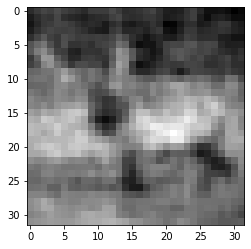

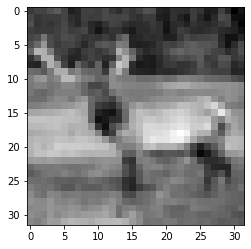

In [0]:
shadow_result = shadow_model(shadow_x_train)
print("MAPE in total: %s." % (MAPE(shadow_input_size, shadow_result, x_train)))

evaluate_index = 528
print("MAPE for image #%s is %s." % (evaluate_index, MAPE_index(evaluate_index, shadow_result, x_train)))

plt.imshow(shadow_img(evaluate_index, shadow_result).reshape(32, 32), cmap='gray')
plt.show()

plt.imshow(train_img(evaluate_index, x_train).reshape(32, 32), cmap='gray')
plt.show()

In [0]:
# Evaluation 1: Different model with same number of images

shadow_imgs_for_evaluate = [1, 9, 18, 35, 115, 128]
shadow_model_sizes = [64, 128, 192, 256]
shadow_model_fn = {
  64: create_shadow_model_64,
  128: create_shadow_model_128,
  192: create_shadow_model_192,
  256: create_shadow_model_256
}

# Standard test
shadow_input_dim = 200
shadow_output_dim = 1024
shadow_input_size = 1000

shadow_epochs = 20000
shadow_learning_rate = 5e-4
shadow_optimizer = keras.optimizers.Adam(learning_rate=shadow_learning_rate)
shadow_lossfn = keras.losses.MeanSquaredError()
#shadow_model.summary()

eva1_shadow_losses = []
eva1_shadow_MAPE = []
eva1_shadow_imgs_for_eva = []

for model_size in shadow_model_sizes:
  print("Test with shadow model last dense layer size %s: " % (model_size))

  shadow_model = shadow_model_fn[model_size](shadow_input_dim, shadow_output_dim)
  shadow_model.summary()
  (shadow_x_train, shadow_y_train) = create_shadow_data(x_train, shadow_input_size, shadow_input_dim)
  shadow_train_dataset = tf.data.Dataset.from_tensor_slices((shadow_x_train, shadow_y_train))
  shadow_losses_for_size = []
  shadow_MAPE_for_size = []
  shadow_imgs_for_eva_for_size = []
  # Iterate over epochs.
  for epoch in range(shadow_epochs):
    #print(epoch)
    shadow_loss_val = 0.0
    shadow_loss_epoch = 0.0
    shadow_steps_epoch = 0
    batched_train_dataset = shadow_train_dataset.shuffle(buffer_size=1024).batch(100)
    for step, (x_batch_train, y_batch_train) in enumerate(batched_train_dataset):
      shadow_steps_epoch += 1
      with tf.GradientTape() as tape:
        shadow_logits = shadow_model(x_batch_train) 
        shadow_loss_val = shadow_lossfn(y_batch_train, shadow_logits)
        shadow_loss_epoch += float(shadow_loss_val)
        shadow_grads = tape.gradient(shadow_loss_val, shadow_model.trainable_weights)
        shadow_optimizer.apply_gradients(zip(shadow_grads, shadow_model.trainable_weights))
      if (epoch+1) % 5000 == 0:
        print('Training loss at epoch %s %s' % (epoch, float(shadow_loss_val)))
    if (epoch+1) % 1000 == 0:
      #shadow_losses_for_size.append(float(shadow_loss_val))
      shadow_losses_for_size.append(float(shadow_loss_epoch/shadow_steps_epoch))
      shadow_res_epoch = shadow_model(shadow_x_train)
      shadow_MAPE_for_size.append(MAPE(shadow_input_size, shadow_res_epoch, x_train))
    if epoch+1 == shadow_epochs:
      shadow_res_epoch = shadow_model(shadow_x_train)
      for img_index_for_evaluate in shadow_imgs_for_evaluate:
        shadow_imgs_for_eva_for_size.append(shadow_img(img_index_for_evaluate, shadow_res_epoch))
      eva1_shadow_imgs_for_eva.append(shadow_imgs_for_eva_for_size)

  eva1_shadow_losses.append(shadow_losses_for_size)
  eva1_shadow_MAPE.append(shadow_MAPE_for_size)

eva1_train_imgs_for_eva = []
for img_index_for_evaluate in shadow_imgs_for_evaluate:
  eva1_train_imgs_for_eva.append(train_img(img_index_for_evaluate, x_train))
eva1_shadow_imgs_for_eva.append(eva1_train_imgs_for_eva)

Test with shadow model last dense layer size 64: 
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shadow_input (InputLayer)    [(None, 200)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                16448     
_________________________________________________________________
predict (Dense)              (None, 1024)              66560     
Total params: 141,760
Trainable params: 141,760
Non-trainable params: 0
_________________________________________________________________
Training loss at epoch 4999 0.009726474061608315
Training loss at epoch

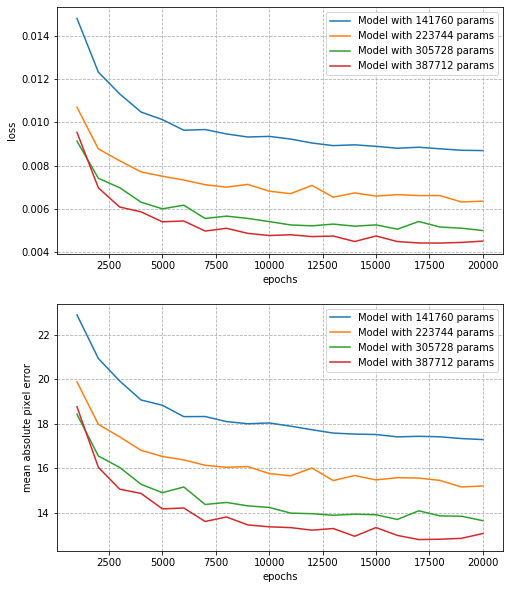

In [0]:
# Figures for evaluation 1

plot_x_epochs = [ (epoch+1)*1000 for epoch in range(int(shadow_epochs/1000))]
shadow_model_param_num = { 64: 141760, 128: 223744, 192: 305728, 256: 387712 }

eva1_stat_figure = plt.figure(figsize=(8,10))

eva1_loss_plot = eva1_stat_figure.add_subplot(2, 1, 1)
eva1_loss_plot.grid(linestyle='--')
eva1_loss_plot.set_xlabel('epochs')
eva1_loss_plot.set_ylabel('loss')
for size in range(len(shadow_model_sizes)):
  label = "Model with {} params".format(shadow_model_param_num[shadow_model_sizes[size]])
  eva1_loss_plot.plot(plot_x_epochs, eva1_shadow_losses[size], label=label)
eva1_loss_plot.legend()

eva1_MAPE_plot = eva1_stat_figure.add_subplot(2, 1, 2)
eva1_MAPE_plot.grid(linestyle='--')
eva1_MAPE_plot.set_xlabel('epochs')
eva1_MAPE_plot.set_ylabel('mean absolute pixel error')
for size in range(len(shadow_model_sizes)):
  label = "Model with {} params".format(shadow_model_param_num[shadow_model_sizes[size]])
  eva1_MAPE_plot.plot(plot_x_epochs, eva1_shadow_MAPE[size], label=label)
eva1_MAPE_plot.legend()

plt.show()

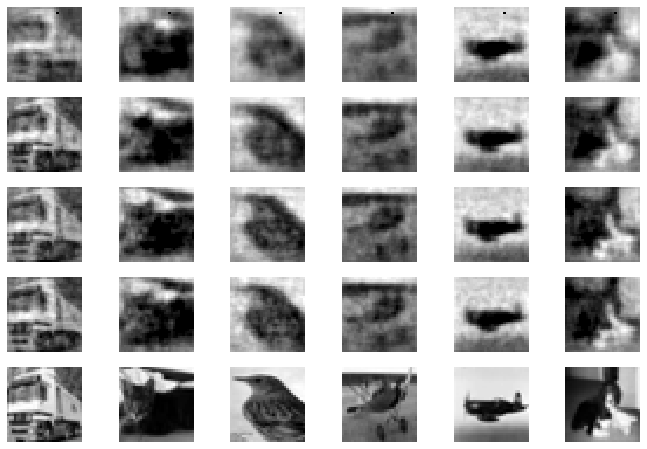

In [0]:
# Imgs for evaluation 1

eva1_img_figure = plt.figure()
eva1_img_cols = len(eva1_shadow_imgs_for_eva[0])
eva1_img_rows = len(eva1_shadow_imgs_for_eva)
for row in range(eva1_img_rows):
  for col in range(eva1_img_cols):
    cur_index = eva1_img_cols * row + col + 1
    cur_img = eva1_img_figure.add_subplot(eva1_img_rows, eva1_img_cols, cur_index)
    cur_img.axis('off')
    plt.imshow(eva1_shadow_imgs_for_eva[row][col].reshape(32, 32), cmap='gray')
eva1_img_figure.set_size_inches(np.array(eva1_img_figure.get_size_inches())*2)
plt.subplots_adjust(wspace=0)
plt.show()

In [0]:
# Evaluation 2: Same model with different numbers of images

shadow_input_sizes = [400, 600, 800, 1000, 1200]
shadow_imgs_for_evaluate = [1, 9, 18, 35, 115, 128]

# Standard test
shadow_input_dim = 200
shadow_output_dim = 1024
shadow_input_size = 600

shadow_epochs = 20000
shadow_learning_rate = 5e-4
shadow_optimizer = keras.optimizers.Adam(learning_rate=shadow_learning_rate)
shadow_lossfn = keras.losses.MeanSquaredError()
#shadow_model.summary()

eva2_shadow_losses = []
eva2_shadow_MAPE = []
eva2_shadow_imgs_for_eva = []

for size in shadow_input_sizes:
  shadow_input_size = size
  print("Test with shadow model input size %s: " % (shadow_input_size))

  shadow_model = create_shadow_model_256(shadow_input_dim, shadow_output_dim)
  (shadow_x_train, shadow_y_train) = create_shadow_data(x_train, shadow_input_size, shadow_input_dim)
  shadow_train_dataset = tf.data.Dataset.from_tensor_slices((shadow_x_train, shadow_y_train))
  shadow_losses_for_size = []
  shadow_MAPE_for_size = []
  shadow_imgs_for_eva_for_size = []
  # Iterate over epochs.
  for epoch in range(shadow_epochs):
    #print(epoch)
    shadow_loss_val = 0.0
    shadow_loss_epoch = 0.0
    shadow_steps_epoch = 0
    batched_train_dataset = shadow_train_dataset.shuffle(buffer_size=1024).batch(100)
    for step, (x_batch_train, y_batch_train) in enumerate(batched_train_dataset):
      shadow_steps_epoch += 1
      with tf.GradientTape() as tape:
        shadow_logits = shadow_model(x_batch_train) 
        shadow_loss_val = shadow_lossfn(y_batch_train, shadow_logits)
        shadow_loss_epoch += float(shadow_loss_val)
        shadow_grads = tape.gradient(shadow_loss_val, shadow_model.trainable_weights)
        shadow_optimizer.apply_gradients(zip(shadow_grads, shadow_model.trainable_weights))
      if (epoch+1) % 5000 == 0:
        print('Training loss at epoch %s %s' % (epoch, float(shadow_loss_val)))
    if (epoch+1) % 1000 == 0:
      #shadow_losses_for_size.append(float(shadow_loss_val))
      shadow_losses_for_size.append(float(shadow_loss_epoch/shadow_steps_epoch))
      shadow_res_epoch = shadow_model(shadow_x_train)
      shadow_MAPE_for_size.append(MAPE(shadow_input_size, shadow_res_epoch, x_train))
    if epoch+1 == shadow_epochs:
      shadow_res_epoch = shadow_model(shadow_x_train)
      for img_index_for_evaluate in shadow_imgs_for_evaluate:
        shadow_imgs_for_eva_for_size.append(shadow_img(img_index_for_evaluate, shadow_res_epoch))
      eva2_shadow_imgs_for_eva.append(shadow_imgs_for_eva_for_size)

  eva2_shadow_losses.append(shadow_losses_for_size)
  eva2_shadow_MAPE.append(shadow_MAPE_for_size)

train_imgs_for_eva = []
for img_index_for_evaluate in shadow_imgs_for_evaluate:
  train_imgs_for_eva.append(train_img(img_index_for_evaluate, x_train))
eva2_shadow_imgs_for_eva.append(train_imgs_for_eva)

Test with shadow model input size 400: 
Training loss at epoch 4999 0.0005059174145571887
Training loss at epoch 4999 0.0005728797405026853
Training loss at epoch 4999 0.0005638263537548482
Training loss at epoch 4999 0.0005458825617097318
Training loss at epoch 9999 0.0003953932609874755
Training loss at epoch 9999 0.0004075928882230073
Training loss at epoch 9999 0.00038815406151115894
Training loss at epoch 9999 0.00040437615825794637
Training loss at epoch 14999 0.0003295095229987055
Training loss at epoch 14999 0.00035444876994006336
Training loss at epoch 14999 0.00035179752740077674
Training loss at epoch 14999 0.0003619033086579293
Training loss at epoch 19999 0.00035788893001154065
Training loss at epoch 19999 0.0003456312115304172
Training loss at epoch 19999 0.00036048219772055745
Training loss at epoch 19999 0.0003744868154171854
Test with shadow model input size 600: 
Training loss at epoch 4999 0.0014197113923728466
Training loss at epoch 4999 0.00145533902104944
Training

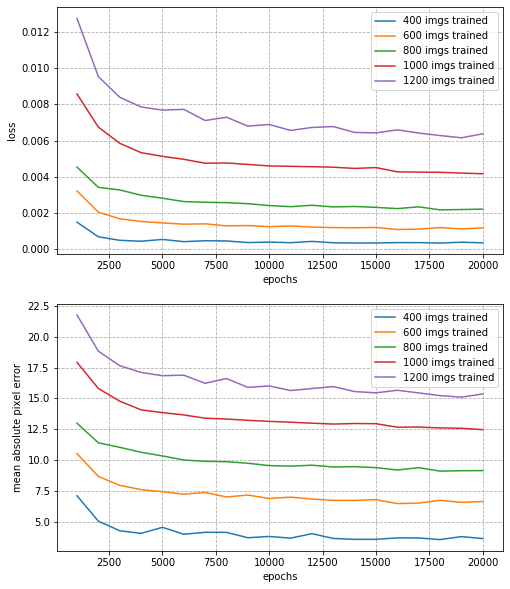

In [0]:
# Figures for evaluation 2

plot_x_epochs = [ (epoch+1)*1000 for epoch in range(int(shadow_epochs/1000))]

eva2_stat_figure = plt.figure(figsize=(8,10))

eva2_loss_plot = eva2_stat_figure.add_subplot(2, 1, 1)
eva2_loss_plot.grid(linestyle='--')
eva2_loss_plot.set_xlabel('epochs')
eva2_loss_plot.set_ylabel('loss')
for size in range(len(shadow_input_sizes)):
  label = "{} imgs trained".format(shadow_input_sizes[size])
  eva2_loss_plot.plot(plot_x_epochs, eva2_shadow_losses[size], label=label)
eva2_loss_plot.legend()

eva2_MAPE_plot = eva2_stat_figure.add_subplot(2, 1, 2)
eva2_MAPE_plot.grid(linestyle='--')
eva2_MAPE_plot.set_xlabel('epochs')
eva2_MAPE_plot.set_ylabel('mean absolute pixel error')
for size in range(len(shadow_input_sizes)):
  label = "{} imgs trained".format(shadow_input_sizes[size])
  eva2_MAPE_plot.plot(plot_x_epochs, eva2_shadow_MAPE[size], label=label)
eva2_MAPE_plot.legend()

plt.show()

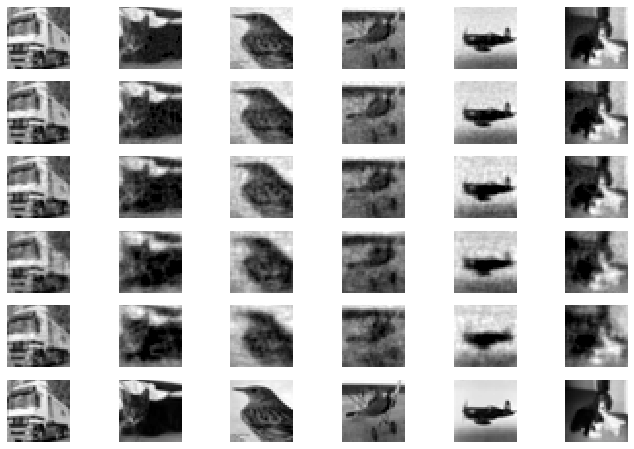

In [0]:
# Images for evaluation 2

eva2_img_figure = plt.figure()
eva2_img_cols = len(eva2_shadow_imgs_for_eva[0])
eva2_img_rows = len(eva2_shadow_imgs_for_eva)
for row in range(eva2_img_rows):
  for col in range(eva2_img_cols):
    cur_index = eva2_img_cols * row + col + 1
    cur_img = eva2_img_figure.add_subplot(eva2_img_rows, eva2_img_cols, cur_index)
    cur_img.axis('off')
    plt.imshow(eva2_shadow_imgs_for_eva[row][col].reshape(32, 32), cmap='gray')
eva2_img_figure.set_size_inches(np.array(eva2_img_figure.get_size_inches())*2)
plt.subplots_adjust(wspace=0)
plt.show()